In [79]:
import numpy as np
import gdal
import glob
import os
import datetime
from scipy.interpolate import griddata
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from collections import Counter
import re
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [80]:
# Collect TA Files
file_dict = {
    'TA' : glob.glob('MODIS_TA/MOD14*FireMask*.tif'),
    'TA_QC' : glob.glob('MODIS_TA/*QA*.tif'),
}

In [81]:
# Open files and store as netcdfs
def open_xarray(data, file_dict):
    """
    Opens dataset as an xarray DataArray.
    
    :param data: key from file_dict
    :param file_dict: dictionary of file paths
    
    :returns: xarray data structure"""
    v = file_dict[data]
    pat = r'doy(\d{7})'
    da_list = []
    for fp in v:
        time = re.findall(pat, fp)[0]
        year = int(time[:4])
        day = int(time[-3:])
        da = xr.open_rasterio(fp)
        dt = (datetime.datetime(year, 1, 1) + datetime.timedelta(day - 1))
        da = da.assign_coords(time=dt)
        da_list.append(da)
    da = xr.concat(da_list, dim='time').squeeze()
    da.name = data
    da.values = da.values * eval(da.attrs['scale_factor'])  # apply scale factor 
    
    return da

In [82]:
ta = np.ma.masked_equal(open_xarray('TA', file_dict), 0)
np.unique(ta, return_counts=True)

(masked_array(data=[3, 4, 5, 6, 7, 8, 9, --],
              mask=[False, False, False, False, False, False, False,  True],
        fill_value=0,
             dtype=uint8),
 array([ 1123573,   278799, 21927173,     3889,      567,     5084,
            8400, 46558717]))

In [83]:
# find all pixels where nominal or high confidence is present
ta_example = ta[16]
fires = list(np.where((ta_example == 8)|(ta_example == 9)))

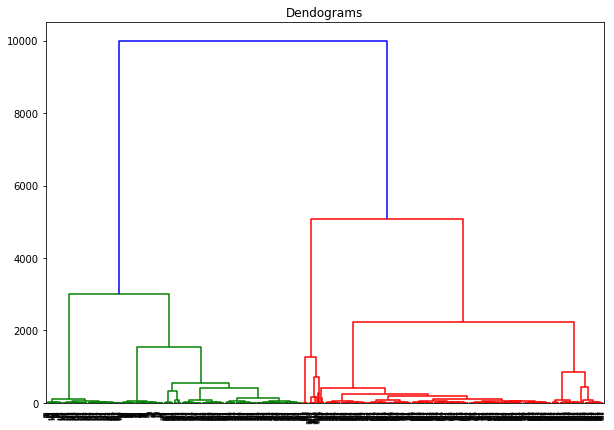

In [84]:
vectors = np.column_stack((fires[0],fires[1]))

plt.figure(figsize=(10, 7))
plt.title("Dendograms")
dend = shc.dendrogram(shc.linkage(vectors, method='ward'))

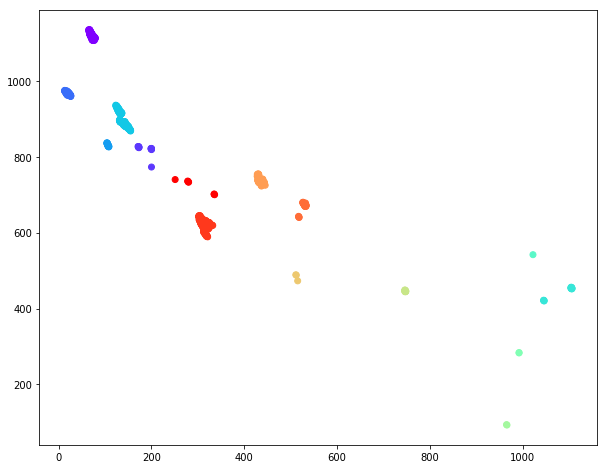

In [85]:
# Do agglomerative clustering based on euclidean distance (voorhees method), keeping threshold on max no of clusters
Z = linkage(vectors, 'complete')
clusters=fcluster(Z, t=15, criterion='maxclust')
np.unique(clusters)
plt.figure(figsize=(10, 8))
plt.scatter(vectors[:,0], vectors[:,1], c=clusters, cmap='rainbow')
plt.show()

In [86]:
data = {'X':fires[0],'Y':fires[1],'Cluster':clusters}
df = pd.DataFrame(data)
c = Counter(clusters)
# get 5 biggest clusters
top5 = c.most_common(5)
def Extract(lst): 
    return [item[0] for item in lst]
selected_clusters = Extract(top5)
df = df.loc[df['Cluster'].isin(selected_clusters)]

In [87]:
dp_list = df.groupby('Cluster').agg(lambda x: list(x))

In [88]:
dp_frame = pd.DataFrame()
for i in range(0, 47):
    ta_sub = ta[i]
    fires = list(np.where((ta_sub == 8)|(ta_sub == 9)))
    vectors = np.column_stack((fires[0],fires[1]))
    Z = linkage(vectors, 'complete')
    R = inconsistent(Z)
    MR = maxRstat(Z, R, 3)
    clusters=fcluster(Z, t=15, criterion='maxclust')
    data = {'X':fires[0],'Y':fires[1],'Cluster':clusters}
    df = pd.DataFrame(data)
    c = Counter(clusters)
    top5 = c.most_common(5)
    selected_clusters = Extract(top5)
    df = df.loc[df['Cluster'].isin(selected_clusters)]
    dp_frame = dp_frame.append(df.groupby('Cluster').agg(lambda x: list(x)))

In [89]:
dp_frame = dp_frame.reset_index()
dp_frame = dp_frame.drop(['Cluster'],axis=1)

In [90]:
# pixel square area in meters
pixel_dim = 858624.6244
pixel_counts = []
for index, row in dp_frame.iterrows():
    pixel_counts.append(len(dp_frame.iloc[index][0]))
area_list = [i * pixel_dim for i in pixel_counts]
# add area of fire patches
dp_frame['Area'] = area_list

In [91]:
fires = []

# combine x and y coordinates to form data points in each fire patch
for index, row in dp_frame.iterrows():
    # list to store a patch's points in
    fire_points = []
    patch = dp_frame.loc[index]
    for coord in range(0, len(patch[0])):
        fire_points.append([patch[0][coord], patch[1][coord]])
    fires.append(fire_points)

In [93]:
dp_frame['Fire Coordinates'] = fires
dp_frame.to_csv('fire_patches.csv')
dp_frame

,X,Y,Area,Fire Coordinates
0,"[635, 637, 638, 652, 652, 653, 653, 654, 654, ...","[511, 476, 475, 491, 492, 497, 498, 488, 496, ...",3.005186e+07,"[[635, 511], [637, 476], [638, 475], [652, 491..."
1,"[639, 639, 639, 640, 640, 640, 640, 640, 641, ...","[327, 407, 408, 325, 326, 327, 328, 329, 323, ...",3.348636e+07,"[[639, 327], [639, 407], [639, 408], [640, 325..."
2,"[274, 275, 335, 335, 336, 336, 336, 336, 336, ...","[638, 637, 644, 645, 643, 644, 645, 646, 647, ...",4.293123e+07,"[[274, 638], [275, 637], [335, 644], [335, 645..."
3,"[448, 448, 449, 451, 452, 452, 452, 516, 516, ...","[676, 677, 674, 692, 690, 691, 692, 711, 712, ...",2.661736e+07,"[[448, 676], [448, 677], [449, 674], [451, 692..."
4,"[37, 37, 38, 38, 39, 68, 68, 69, 69, 69, 69, 6...","[1064, 1065, 1063, 1064, 1063, 1051, 1052, 104...",2.747599e+07,"[[37, 1064], [37, 1065], [38, 1063], [38, 1064..."
5,"[673, 673, 673, 674, 674, 674, 674, 674, 675, ...","[484, 485, 486, 483, 484, 485, 486, 487, 482, ...",1.030350e+07,"[[673, 484], [673, 485], [673, 486], [674, 483..."
6,"[724, 724, 725, 725, 739, 740, 740, 740, 740, ...","[451, 452, 451, 452, 418, 416, 417, 418, 419, ...",9.444871e+06,"[[724, 451], [724, 452], [725, 451], [725, 452..."
7,"[269, 269, 270, 270, 340, 341, 343, 344, 344, ...","[750, 751, 749, 750, 693, 739, 699, 698, 699, ...",9.444871e+06,"[[269, 750], [269, 751], [270, 749], [270, 750..."
8,"[456, 457, 457, 458, 458, 459, 459, 459, 460, ...","[583, 566, 567, 566, 579, 577, 578, 579, 578, ...",8.586246e+06,"[[456, 583], [457, 566], [457, 567], [458, 566..."
9,"[365, 366, 366, 366, 367, 367, 367, 367, 368, ...","[625, 625, 626, 627, 623, 624, 625, 626, 622, ...",1.202074e+07,"[[365, 625], [366, 625], [366, 626], [366, 627..."
